# Tutorial: Building custom geometries with PINA `DomainInterface` class

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mathLab/PINA/blob/master/tutorials/tutorial6/tutorial.ipynb)

In this tutorial we will show how to use geometries in PINA. Specifically, the tutorial will include how to create geometries and how to visualize them. The topics covered are:

* Creating CartesianDomains and EllipsoidDomains
* Getting the Union and Difference of Geometries
* Sampling points in the domain (and visualize them)

We import the relevant modules first.

In [ ]:
## routine needed to run the notebook on Google Colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
  !pip install "pina-mathlab"

import matplotlib.pyplot as plt

from pina.domain import EllipsoidDomain, Difference, CartesianDomain, Union, SimplexDomain, DomainInterface
from pina.label_tensor import LabelTensor

def plot_scatter(ax, pts, title):
    ax.title.set_text(title)
    ax.scatter(pts.extract('x'), pts.extract('y'), color='blue', alpha=0.5)

## Built-in Geometries

We will create one cartesian and two ellipsoids. For the sake of simplicity, we show here the 2-dimensional case, but the extension to 3D (and higher) cases is trivial. The geometries allow also the generation of samples belonging to the boundary. So, we will create one ellipsoid with the border and one without.

In [ ]:
cartesian = CartesianDomain({"x": [0, 2], "y": [0, 2]})
ellipsoid_no_border = EllipsoidDomain({"x": [1, 3], "y": [1, 3]})
ellipsoid_border = EllipsoidDomain(
    {"x": [2, 4], "y": [2, 4]}, sample_surface=True
)

The `{'x': [0, 2], 'y': [0, 2]}` are the bounds of the `CartesianDomain` being created. 

To visualize these shapes, we need to sample points on them. We will use the `sample` method of the `CartesianDomain` and `EllipsoidDomain` classes. This method takes a `n` argument which is the number of points to sample. It also takes different modes to sample, such as `'random'`.

In [ ]:
cartesian_samples = cartesian.sample(n=1000, mode="random")
ellipsoid_no_border_samples = ellipsoid_no_border.sample(n=1000, mode="random")
ellipsoid_border_samples = ellipsoid_border.sample(n=1000, mode="random")

We can see the samples of each geometry to see what we are working with.

In [4]:
print(f"Cartesian Samples: {cartesian_samples}")
print(f"Ellipsoid No Border Samples: {ellipsoid_no_border_samples}")
print(f"Ellipsoid Border Samples: {ellipsoid_border_samples}")

Cartesian Samples: 1: {'dof': ['x', 'y'], 'name': 1}

tensor([[0.1086, 1.7192],
        [0.0194, 1.5690],
        [0.7047, 1.3665],
        ...,
        [0.5924, 0.8842],
        [0.1326, 1.2767],
        [0.6012, 0.9822]])
Ellipsoid No Border Samples: 1: {'dof': ['x', 'y'], 'name': 1}

tensor([[2.0577, 2.0362],
        [1.5990, 2.4981],
        [1.9673, 2.9884],
        ...,
        [1.4765, 2.1523],
        [1.9655, 2.0474],
        [2.9667, 2.0016]])
Ellipsoid Border Samples: 1: {'dof': ['x', 'y'], 'name': 1}

tensor([[2.0763, 2.6168],
        [3.8528, 2.4777],
        [3.1241, 2.0077],
        ...,
        [2.3080, 3.7219],
        [2.5890, 2.0884],
        [2.5648, 3.9003]])


Notice how these are all `LabelTensor` objects. You can read more about these in the [documentation](https://mathlab.github.io/PINA/_rst/label_tensor.html). At a very high level, they are tensors where each element in a tensor has a label that we can access by doing `<tensor_name>.labels`. We can also access the values of the tensor by doing `<tensor_name>.extract(['x'])`.

We are now ready to visualize the samples using matplotlib.

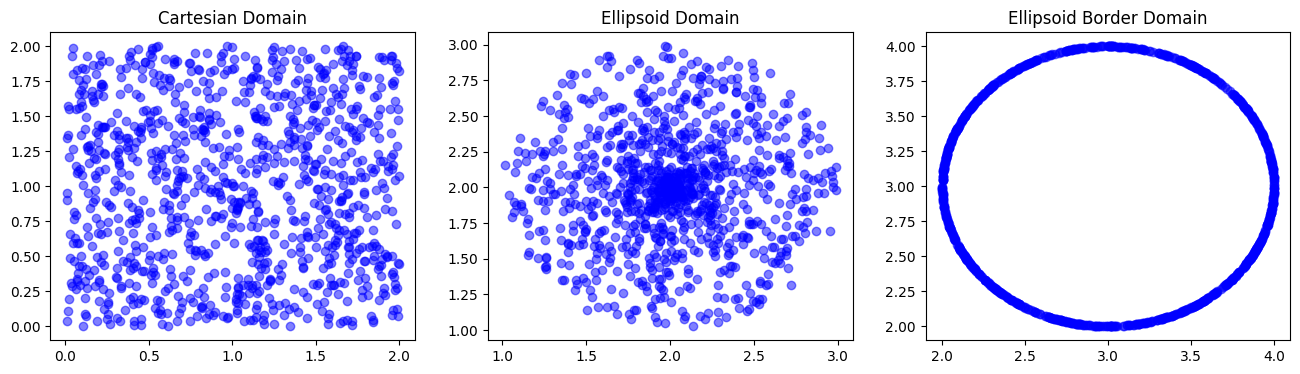

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
pts_list = [
    cartesian_samples,
    ellipsoid_no_border_samples,
    ellipsoid_border_samples,
]
title_list = ["Cartesian Domain", "Ellipsoid Domain", "Ellipsoid Border Domain"]
for ax, pts, title in zip(axs, pts_list, title_list):
    plot_scatter(ax, pts, title)

We have now created, sampled, and visualized our first geometries! We can see that the `EllipsoidDomain` with the border has a border around it. We can also see that the `EllipsoidDomain` without the border is just the ellipse. We can also see that the `CartesianDomain` is just a square.

### Simplex Domain

Among the built-in shapes, we quickly show here the usage of `SimplexDomain`, which can be used for polygonal domains!

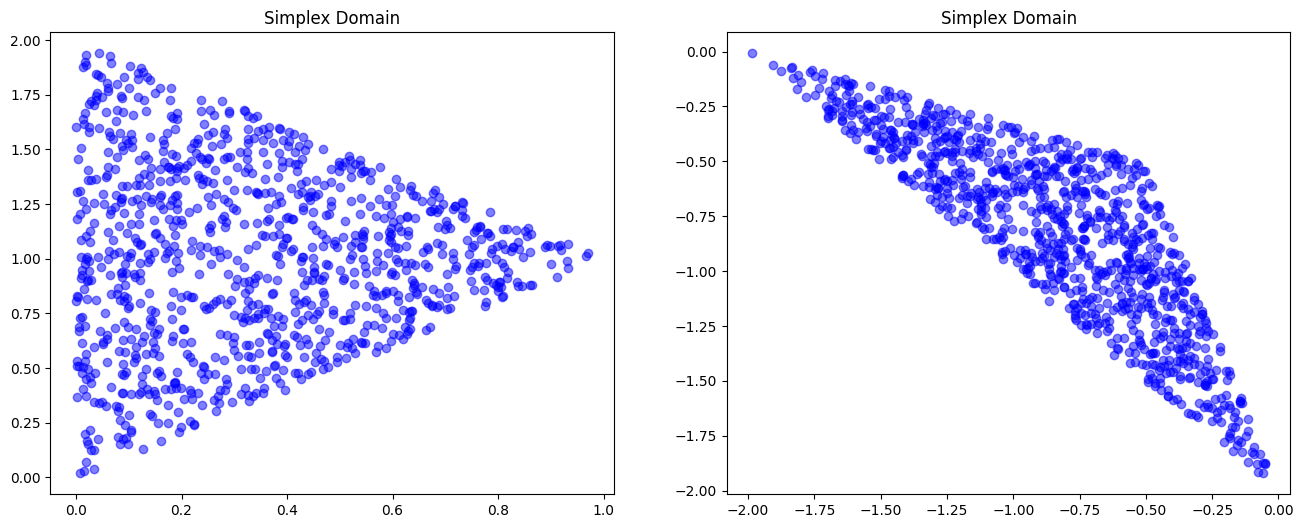

In [ ]:
import torch

spatial_domain = SimplexDomain(
    [
        LabelTensor(torch.tensor([[0, 0]]), labels=["x", "y"]),
        LabelTensor(torch.tensor([[1, 1]]), labels=["x", "y"]),
        LabelTensor(torch.tensor([[0, 2]]), labels=["x", "y"]),
    ]
)

spatial_domain2 = SimplexDomain(
    [
        LabelTensor(torch.tensor([[0.0, -2.0]]), labels=["x", "y"]),
        LabelTensor(torch.tensor([[-0.5, -0.5]]), labels=["x", "y"]),
        LabelTensor(torch.tensor([[-2.0, 0.0]]), labels=["x", "y"]),
    ]
)

pts = spatial_domain2.sample(100)
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
for domain, ax in zip([spatial_domain, spatial_domain2], axs):
    pts = domain.sample(1000)
    plot_scatter(ax, pts, "Simplex Domain")

## Boolean Operations

To create complex shapes we can use the boolean operations, for example to merge two default geometries. We need to simply use the `Union` class: it takes a list of geometries and returns the union of them.

Let's create three unions. Firstly, it will be a union of `cartesian` and `ellipsoid_no_border`. Next, it will be a union of `ellipse_no_border` and `ellipse_border`. Lastly, it will be a union of all three geometries.

In [7]:
cart_ellipse_nb_union = Union([cartesian, ellipsoid_no_border])
cart_ellipse_b_union = Union([cartesian, ellipsoid_border])
three_domain_union = Union([cartesian, ellipsoid_no_border, ellipsoid_border])

We can of course sample points over the new geometries, by using the `sample` method as before. We highlight that the available sample strategy here is only *random*.

In [ ]:
c_e_nb_u_points = cart_ellipse_nb_union.sample(n=2000, mode="random")
c_e_b_u_points = cart_ellipse_b_union.sample(n=2000, mode="random")
three_domain_union_points = three_domain_union.sample(n=3000, mode="random")

We can plot the samples of each of the unions to see what we are working with.

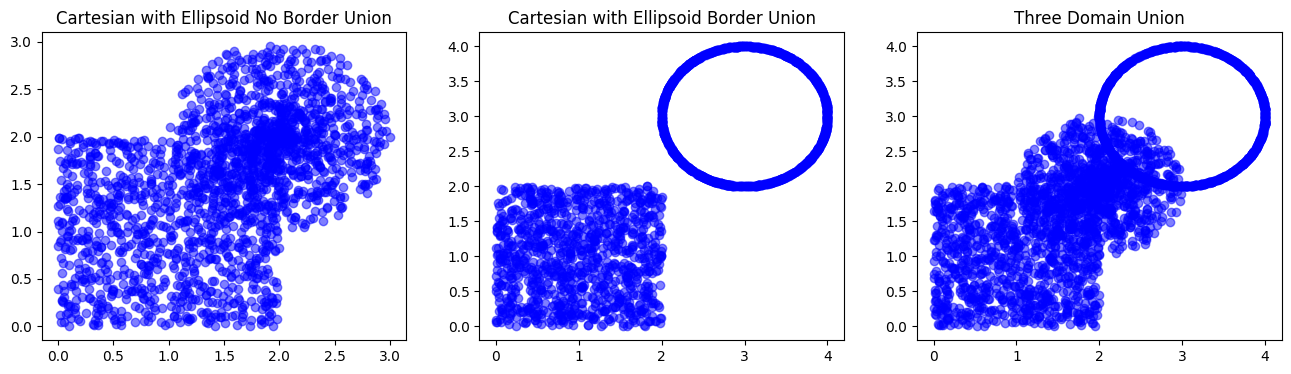

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
pts_list = [c_e_nb_u_points, c_e_b_u_points, three_domain_union_points]
title_list = [
    "Cartesian with Ellipsoid No Border Union",
    "Cartesian with Ellipsoid Border Union",
    "Three Domain Union",
]
for ax, pts, title in zip(axs, pts_list, title_list):
    plot_scatter(ax, pts, title)

Now, we will find the differences of the geometries. We will find the difference of `cartesian` and `ellipsoid_no_border`.

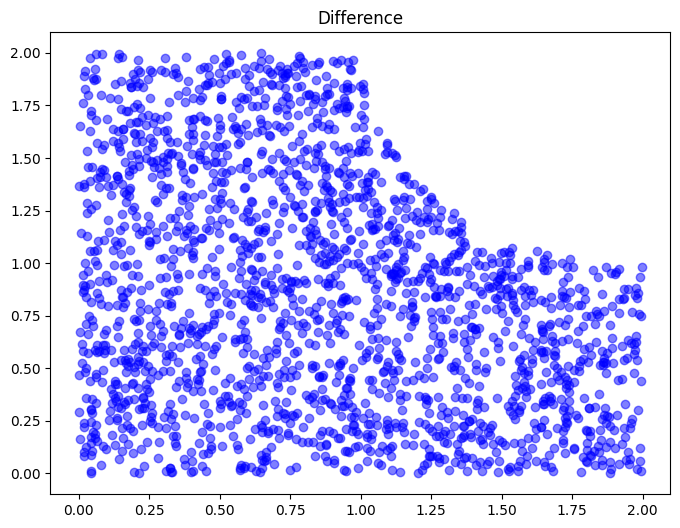

In [ ]:
cart_ellipse_nb_difference = Difference([cartesian, ellipsoid_no_border])
c_e_nb_d_points = cart_ellipse_nb_difference.sample(n=2000, mode="random")

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_scatter(ax, c_e_nb_d_points, "Difference")

## Create Custom DomainInterface

We will take a look on how to create our own geometry. The one we will try to make is a heart defined by the function $$(x^2+y^2-1)^3-x^2y^3 \le 0$$

Let's start by importing what we will need to create our own geometry based on this equation.

In [11]:
import torch
from pina import LabelTensor

Next, we will create the `Heart(DomainInterface)` class and initialize it.

In [ ]:
class Heart(DomainInterface):
    """Implementation of the Heart Domain."""

    def __init__(self, sample_border=False):
        super().__init__()

Because the `DomainInterface` class we are inheriting from requires both a `sample` method and `is_inside` method, we will create them and just add in "pass" for the moment. We also observe that the methods `sample_modes` and `variables` of the `DomainInterface` class are initialized as `abstractmethod`, so we need to redefine them both in the subclass `Heart` .

In [ ]:
class Heart(DomainInterface):
    """Implementation of the Heart Domain."""

    def __init__(self, sample_border=False):
        super().__init__()

    def is_inside(self):
        pass

    def sample(self):
        pass

    @property
    def sample_modes(self):
        pass

    @property
    def variables(self):
        pass

Now we have the skeleton for our `Heart` class.  Also the `sample` method is where most of the work is done so let's fill it out. 

In [ ]:
class Heart(DomainInterface):
    """Implementation of the Heart Domain."""

    def __init__(self, sample_border=False):
        super().__init__()

    def is_inside(self):
        pass

    def sample(self, n):
        sampled_points = []

        while len(sampled_points) < n:
            x = torch.rand(1) * 3.0 - 1.5
            y = torch.rand(1) * 3.0 - 1.5
            if ((x**2 + y**2 - 1) ** 3 - (x**2) * (y**3)) <= 0:
                sampled_points.append([x.item(), y.item()])

        return LabelTensor(torch.tensor(sampled_points), labels=["x", "y"])

    @property
    def sample_modes(self):
        pass

    @property
    def variables(self):
        pass

To create the Heart geometry we simply run:

In [15]:
heart = Heart()

To sample from the Heart geometry we simply run:

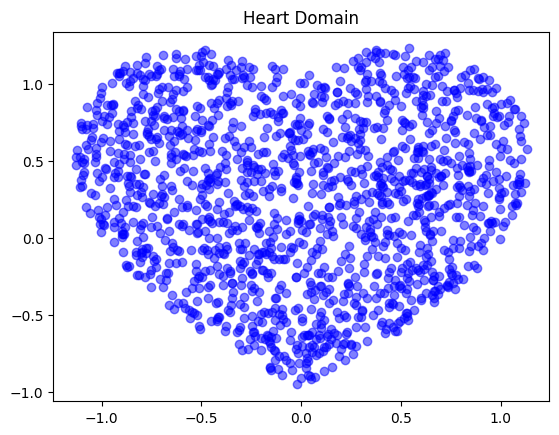

In [ ]:
pts_heart = heart.sample(1500)

fig, ax = plt.subplots()
plot_scatter(ax, pts_heart, "Heart Domain")

## What's next?

We have made a very simple tutorial on how to build custom geometries and use domain operation to compose base geometries. Now you can play around with different geometries and build your own!  